# Create a Python list from the .json tweets file

In [1]:
import json
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

#create a file to contain the 'raw data' from the twitter streaming api
raw_data_path = 'starwars_tweets.txt'

#create a list to hold the tweets
raw_data = []

#create and open the new file
tweets_file = open(raw_data_path, "r")

#append to the tweets list from the raw data file
for line in tweets_file:
    try:
        tweet = json.loads(line)
        raw_data.append(tweet)
    except:
        continue       
print "Number of tweets - ", len(raw_data)

Number of tweets -  120761


# Do an initial analysis of the data

In [2]:
tweets = pd.DataFrame()

In [3]:
#removed u'possibly_sensitive', at the moment since not all rows have it
#it goes between place and retweet_count in the below list
twitter_fields = [u'contributors', u'coordinates', u'created_at', u'entities', 
                  u'favorite_count', u'favorited', u'geo', u'id', 
                  u'id_str', u'in_reply_to_screen_name', u'in_reply_to_status_id', 
                  u'in_reply_to_status_id_str', u'in_reply_to_user_id', u'in_reply_to_user_id_str', 
                  u'lang', u'place',   u'retweet_count', u'retweeted', u'source', 
                  u'text', u'truncated', u'user']

#set the columns in the dataframe to match the json fields of the twitter streaming api
for t in twitter_fields:
    tweets[t] = map(lambda tweet: tweet[t] if tweet[t] else 'None', raw_data)
tweets['followers_count'] = map(lambda tweet: tweet['user']['followers_count'] if tweet['user'] != None else None, raw_data)
tweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, raw_data)

In [4]:
#View the first 5 tweets of the dataset
pd.set_option('max_colwidth', 200)
tweets['text'].head()

0             RT @yisucrist: de k kereis k haga la próxima parodia extrema?\n\nrt si the walking dead\nlaik si star wars\n\nhttps://t.co/lOTMmrM4l0
1                            Here’s How Much Money Star Wars Could Make via https://t.co/ObmsOhtHdG https://t.co/8J6Su277JE https://t.co/YRzIfG8kql
2    RT @DepressedDarth: There's still time to get a gold disc and win a new room, buy stuff here: https://t.co/CxydgZKJ0s\n\n#ShowUsYourForce htt…
3                                                                 I just uploaded "Sixers Star Wars Night Recap" to @Vimeo: https://t.co/Mop0h1RpTt
4                                                                                                            Quien me acompaña a ver Star wars? bue
Name: text, dtype: object

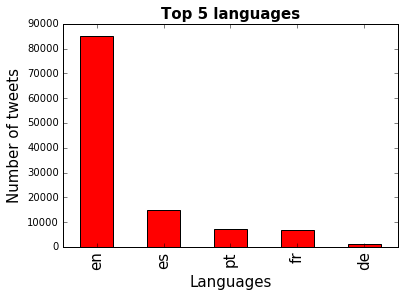

In [5]:
#view the top 5 languages present in the dataset
tweets_by_lang = tweets['lang'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

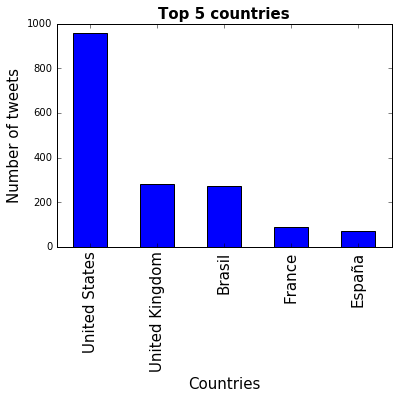

In [6]:
#view the top 5 countries in the dataset
tweets_by_country = tweets['country'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

In [7]:
#we filter out languages other than English
tweets = pd.DataFrame(tweets[tweets['lang'] == 'en'])

print tweets['text'].head()
print "\n"
print "There are", len(tweets), 'tweets in English'

1                            Here’s How Much Money Star Wars Could Make via https://t.co/ObmsOhtHdG https://t.co/8J6Su277JE https://t.co/YRzIfG8kql
2    RT @DepressedDarth: There's still time to get a gold disc and win a new room, buy stuff here: https://t.co/CxydgZKJ0s\n\n#ShowUsYourForce htt…
3                                                                 I just uploaded "Sixers Star Wars Night Recap" to @Vimeo: https://t.co/Mop0h1RpTt
7                   RT @COVOvodka: 4 days until Star Wars and 11 days until Christmas and we don't know what's more exciting... #CelebrateTheMoment
9                                                                                               i hope they all die at the end of the new star wars
Name: text, dtype: object


There are 85115 tweets in English


In [8]:
import re
#create a function to find the word in the tweet text field
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

# Pass the data with to Spark for text processing

In [9]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text
from gensim import corpora 

In [10]:
import findspark
findspark.init()
print findspark.find()

/usr/local/Cellar/apache-spark/1.5.2/libexec/


In [11]:
import pyspark

In [12]:
def get_parts(thetext, punc='.,;:!?()[]{}`''\"@#$^&*+-|=~_'):
    # generate stopwords list & regexes for 2+ periods or 2+ dashes
    stop = text.ENGLISH_STOP_WORDS
    regex1=re.compile(r"\.{2,}")
    regex2=re.compile(r"\-{2,}")
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    punctuation = list(punc)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stop or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stop or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2

In [13]:
# initialize Spark context
conf = pyspark.SparkConf().setAppName("Twitter_Movies").setMaster("local[*]")
sc = pyspark.SparkContext(conf=conf)

In [14]:
# get tweets from text file
#text_lines = sc.textFile('tweets_all@#_7591.json')
#tweets = text_lines.map(json.loads)
#tweets_text = tweets.map(lambda t: t['text'])

# read tweets & associated into Spark
tweets_text = sc.parallelize([(row['text']) for index, row in tweets.iterrows()])

# Sentiment of a sentence based on log probs in a word list

Function to read the word list file:

In [15]:
import numpy as np
# read the word list
def readSentimentList(file_name):
    ifile = open(file_name, 'r')
    happy_log_probs = {}
    sad_log_probs = {}
    ifile.readline() #Ignore title row
    # splitting the csv
    for line in ifile:
        tokens = line[:-1].split(',')
        happy_log_probs[tokens[0]] = float(tokens[1])
        sad_log_probs[tokens[0]] = float(tokens[2])

    return happy_log_probs, sad_log_probs

Using Naive Bayes rule:

In [16]:
def classifySentiment(words, happy_log_probs, sad_log_probs):
    # get the log-probability of each word under each sentiment
    happy_probs = [happy_log_probs[word] for word in words if word in happy_log_probs]
    sad_probs = [sad_log_probs[word] for word in words if word in sad_log_probs]

    # sum all the log-probabilities for each sentiment to get a log-probability for the whole tweet
    tweet_happy_log_prob = np.sum(happy_probs)
    tweet_sad_log_prob = np.sum(sad_probs)

    # calculate the probability of the tweet belonging to each sentiment
    prob_happy = np.reciprocal(np.exp(tweet_sad_log_prob - tweet_happy_log_prob) + 1)
    prob_sad = 1 - prob_happy

    return prob_happy, prob_sad

Load the word list:

In [17]:
# load list of words and log probs
happy_log_probs, sad_log_probs = readSentimentList('wordlist.csv')

Reading in the tweet:

In [18]:
# read tweet
tweet1 = ['my', 'love', 'bambi', '']

# calculate the probability
tweet1_happy_prob, tweet1_sad_prob = classifySentiment(tweet1, happy_log_probs, sad_log_probs)

print tweet1 
print "happy probability: " , tweet1_happy_prob 
print "sad probability:", tweet1_sad_prob

['my', 'love', 'bambi', '']
happy probability:  0.954107296677
sad probability: 0.0458927033232


In [19]:
# get words out for sentiment analysis
puncs = '.,;:!?()[]{}`''\"@#$^&*+-|=~_'
sentiment_words = tweets_text.mapValues(lambda t: t.strip(puncs).split())

# classify sentiment of tweet
tweets_probs = sentiment_words.mapValues(lambda ws: classifySentiment(ws, happy_log_probs, sad_log_probs))
happy_probs = tweets_probs.mapValues(lambda (hprob, sprob): (hprob, 1))
sad_probs = tweets_probs.mapValues(lambda (hprob, sprob): (sprob, 1))

Create an output.csv file to use for visualization

In [22]:
#collect the happy probabilities from the above mapValues call
listOfHappyProbs = happy_probs.collect()

#create an empty list to contain the just the probability portion of happy_probs
HappyProbsList = []
for x in range(len(listOfHappyProbs)):
    HappyProbsList.append(listOfHappyProbs[x][1][0])

#create the following dataframe containing columns of data for visualization
# text, airline, positive, prob, created_at, favorite_count, retweet_count, followers_count
df_data_visualization = pd.DataFrame()
df_data_visualization['created_at'] = tweets['created_at']
df_data_visualization['favorite_count'] = tweets['favorite_count']
df_data_visualization['retweet_count'] = tweets['retweet_count']
df_data_visualization['followers_count'] = tweets['followers_count']
# df_data_visualization['text'] = tweets['text']
# df_data_visualization['airline'] = tweets['airline']
df_data_visualization['prob'] = HappyProbsList

#a function to set a 1 if the happy probability is greater than .5 otherwise set it to 0
#we will use this for the visualization aspect
def setPositiveValues(row):
    if row['prob'] > 0.5:
        return 1
    else:
        return 0

#run the function on the prob column to create the positive column to determine if a tweet is positive or negative
#from the happy probability
df_data_visualization['positive'] = df_data_visualization.apply(setPositiveValues, axis=1)

#create the text column, remove the newlines from the text to resolve an issue with row creation in the .to_csv call
df_data_visualization['text'] = tweets['text'].str.replace('\n',"")

#create a .csv file to use for visualization 
df_data_visualization.to_csv('output.csv', encoding='utf-8', index=False)

In [23]:
tweets['text'].head()

1                            Here’s How Much Money Star Wars Could Make via https://t.co/ObmsOhtHdG https://t.co/8J6Su277JE https://t.co/YRzIfG8kql
2    RT @DepressedDarth: There's still time to get a gold disc and win a new room, buy stuff here: https://t.co/CxydgZKJ0s\n\n#ShowUsYourForce htt…
3                                                                 I just uploaded "Sixers Star Wars Night Recap" to @Vimeo: https://t.co/Mop0h1RpTt
7                   RT @COVOvodka: 4 days until Star Wars and 11 days until Christmas and we don't know what's more exciting... #CelebrateTheMoment
9                                                                                               i hope they all die at the end of the new star wars
Name: text, dtype: object

# Visualization

reading the output file

In [27]:
df = pd.read_csv("output.csv")
#df.to_csv("output.csv", date_format='%Y%m%d')
#getting rid of undecided tweets
df = df[(df.prob <> .5)]
df.head(100)

,created_at,favorite_count,retweet_count,followers_count,prob,positive,text
2231,Mon Dec 14 22:20:14 +0000 2015,None,1,8434,0.703952,1,11 shameless Star Wars-branded foods to put in your pantry https://t.co/5CDs3r7KG5 https://t.co/JvrgCQuqdO
3271,Mon Dec 14 22:16:36 +0000 2015,None,None,769,0.703952,1,11 shameless Star Wars-branded foods to put in your pantry https://t.co/znAcX0JB3r #News 【Geek】
3280,Mon Dec 14 22:16:33 +0000 2015,None,None,270,0.703952,1,#10: Angry Birds Star Wars Premium HD (Kindle Tablet Edition) https://t.co/UqNU6tkves
3356,Mon Dec 14 22:16:19 +0000 2015,None,None,4187,0.703952,1,11 shameless Star Wars-branded foods to put in your pantry: You… https://t.co/FCO5GfSSok #News #campbells #Disney |https://t.co/FcMH4lSOSj
3364,Mon Dec 14 22:16:17 +0000 2015,None,None,5949,0.703952,1,11 shameless Star Wars-branded foods to put in your pantry https://t.co/4q7pkM0qEp
3418,Mon Dec 14 22:16:09 +0000 2015,None,None,11,0.703952,1,11 shameless Star Wars-branded foods to put in your pantry https://t.co/MGEytD2YWC https://t.co/WZcRA5YdZE
3655,Mon Dec 14 22:15:22 +0000 2015,None,None,739,0.703952,1,11 shameless Star Wars-branded foods to put in your pantry https://t.co/wjmcp7Lxna
4060,Mon Dec 14 22:14:13 +0000 2015,None,None,13126,0.703952,1,21 Small Epiphanies That Will Forever Change How You Watch 'Star Wars' - https://t.co/TQT8FQzBYk via @StumbleUpon
4423,Mon Dec 14 22:12:57 +0000 2015,None,None,1219,0.703952,1,21 Small Epiphanies That Will Forever Change How You Watch 'Star Wars' https://t.co/AxWZ4IFptV
4508,Mon Dec 14 22:12:40 +0000 2015,None,None,909,0.703952,1,11 shameless Star Wars-branded foods to put in your pantry https://t.co/3ZzOA8O8dr #geek #turriff #tyres https://t.co/OJ7J97PDxl


In [26]:
print len(df)
print df['text'].head(10)
df['prob'].head(10)

probMean = df['prob'].mean()
print "\n"
print "THE OVERALL POSITIVE SENTIMENT FOR STAR WARS IS - ", probMean

190
2231                                    11 shameless Star Wars-branded foods to put in your pantry https://t.co/5CDs3r7KG5 https://t.co/JvrgCQuqdO
3271                                               11 shameless Star Wars-branded foods to put in your pantry https://t.co/znAcX0JB3r #News 【Geek】
3280                                                         #10: Angry Birds Star Wars Premium HD (Kindle Tablet Edition) https://t.co/UqNU6tkves
3356    11 shameless Star Wars-branded foods to put in your pantry: You… https://t.co/FCO5GfSSok #News #campbells #Disney |https://t.co/FcMH4lSOSj
3364                                                            11 shameless Star Wars-branded foods to put in your pantry https://t.co/4q7pkM0qEp
3418                                    11 shameless Star Wars-branded foods to put in your pantry https://t.co/MGEytD2YWC https://t.co/WZcRA5YdZE
3655                                                            11 shameless Star Wars-branded foods to put in you